In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
bg = '#11134A'
accent = '#202289'
txt = '#FAF9F1'
lilla = '#A084C3'

mpl.rcParams['text.color'] = txt
mpl.rcParams['axes.labelcolor'] = txt
mpl.rcParams['xtick.color'] = txt
mpl.rcParams['ytick.color'] = txt
mpl.rcParams['axes.facecolor'] = bg
mpl.rcParams['axes.edgecolor'] = txt

In [3]:
areas = gpd.read_file( '../../data/aree.geojson' )
areas = areas[["geometry", "NOME_AT"]] # shows epsg:3004, but it's wrong
areas = areas.rename(columns = { "NOME_AT" : "frazione" })
areas = areas.set_crs( "epsg:4326", allow_override = True )
areas = areas.to_crs( epsg = 32633 ) #utm
# print(areas.head(3))
# areas.plot( column = "frazione" )

In [4]:
ateco = pd.read_csv( '../../data/ateco.csv', encoding = 'ISO-8859-1' ) # ateco classification of economic activities
# print(ateco.head(3))

In [5]:
companies = gpd.read_file('../../data/imprese.geojson')
companies = companies[['DENOMINAZI', 'geometry', 'CODICE_ATT']]
companies = companies.to_crs( epsg = 32633 ) # utm
companies = companies.rename( columns = { 'DENOMINAZI' : 'nome', 'CODICE_ATT' : 'ateco' } )
companies = companies.dropna( subset = ['ateco'] ) # delete unspecified companies
companies['ateco'] = companies['ateco'].str.replace( '[A-Z]', '', regex = True ) # the default value of regex will change from True to False in a future version
companies['ateco'] = companies['ateco'].str.replace(' ', '')
companies_ateco = companies['ateco'].str.split( '/', expand = True )
companies_ateco = companies_ateco.add_prefix( 'ateco_' )
companies = companies.drop( columns = ['ateco'] )
companies = pd.concat( [companies, companies_ateco], axis = 1 )
print(companies.head(3))

                                                nome  \
0        CASADIO & VANNINI DI GALLI ALBA E C. S.N.C.   
1  HOTEL BISANZIO-DI FABBRI DONATELLA & C.-SOCIET...   
2  LEGATORIA TIMBRIFICIO UNIVERSO DI MARIO VERITA...   

                         geometry  ateco_0  ateco_1 ateco_2 ateco_3 ateco_4  \
0  POINT (272167.050 4922066.166)  45.20.2  45.20.1   77.11    None    None   
1  POINT (276997.507 4922289.211)     55.1     None    None    None    None   
2  POINT (278236.571 4925807.430)    18.14  32.99.9    None    None    None   

  ateco_5 ateco_6  
0    None    None  
1    None    None  
2    None    None  


In [6]:
companies = companies[['nome', 'geometry', 'ateco_0']]
companies = companies.rename( columns = { 'ateco_0' : 'ateco_cod' } )
ateco = ateco.drop_duplicates( subset = ['ateco_cod'] ) # imprese rows will increase if keys match more than one row in the other df
companies = pd.merge( companies, ateco, how = 'left', on = 'ateco_cod' )
# error = imprese[imprese['ateco_nome'].isna()] # look for untranslated ateco_cod values
print(companies.head(3))

                                                nome  \
0        CASADIO & VANNINI DI GALLI ALBA E C. S.N.C.   
1  HOTEL BISANZIO-DI FABBRI DONATELLA & C.-SOCIET...   
2  LEGATORIA TIMBRIFICIO UNIVERSO DI MARIO VERITA...   

                         geometry ateco_cod  \
0  POINT (272167.050 4922066.166)   45.20.2   
1  POINT (276997.507 4922289.211)      55.1   
2  POINT (278236.571 4925807.430)     18.14   

                                  ateco_nome  
0  Riparazione di carrozzerie di autoveicoli  
1                Alberghi e strutture simili  
2               Legatoria e servizi connessi  


In [7]:
distribution = areas.overlay( companies, how = 'intersection', keep_geom_type = False )
distribution = distribution.drop_duplicates( subset = ['nome'], ignore_index = True )
distribution = distribution.drop( columns = ['nome', 'ateco_nome', 'geometry'] )
# print(distribution.head(3))

In [8]:
distribution = distribution.rename( columns = { 'ateco_cod' : 'companies' } ) # prepare column for count
distribution = distribution.groupby('frazione').count().reset_index()
distribution = distribution.merge( areas, on = 'frazione' )
# print(isinstance(distribution, gpd.GeoDataFrame))
distribution = gpd.GeoDataFrame(distribution)
distribution['areas'] = distribution['geometry'].area  / 10**6 # km
distribution['industry_density'] = round( distribution['companies'] / distribution['areas'], 2 )
print(distribution.head(3)) # ready for indicators df

        frazione  companies  \
0    CASTIGLIONE        978   
1  CENTRO URBANO       3885   
2        DARSENA       1654   

                                            geometry      areas  \
0  POLYGON ((286726.373 4915066.675, 286750.492 4...  80.437160   
1  POLYGON ((278046.280 4925082.213, 278051.049 4...  21.155808   
2  POLYGON ((281218.174 4926652.414, 281326.598 4...  41.587972   

   industry_density  
0             12.16  
1            183.64  
2             39.77  


In [9]:
variety = companies
variety['ateco_cod'] = variety['ateco_cod'].str.split( pat = '.' )
variety['ateco_cod'] = variety['ateco_cod'].str.get(0)

In [10]:
variety_tot = variety[['geometry', 'ateco_cod']].groupby('ateco_cod').count().reset_index()
variety_tot = variety_tot.rename( columns = { 'geometry' : 'tot' } )
variety_tot = pd.merge( variety_tot, ateco, how = 'left', on = 'ateco_cod' )
variety_tot = variety_tot[['ateco_nome', 'tot']]

In [11]:
variety_local = areas.overlay( variety, how = "intersection", keep_geom_type = False )
variety_local = variety_local.drop_duplicates( subset = ['nome'], ignore_index = True )
variety_local = variety_local.groupby('frazione')
# print(variety_local.head(3)) # shows the first three of each group
# print(variety_local.get_group('DEL MARE').head(3))

In [12]:
variety_data = pd.DataFrame( columns = ['frazione', 'types'] ) # ready for indicator df

def distr_analysis(df_input, str_input):
    df = df_input[['ateco_cod', 'nome']]
    df = df.groupby('ateco_cod').count().reset_index()
    global variety_data
    d = { 'frazione' : [str_input], 'types' : [len(df.index)] }
    df_temp = pd.DataFrame( data = d )
    variety_data = pd.concat( [variety_data, df_temp], ignore_index = True )
    return

for name, group in variety_local:
    distr_analysis( group, name )

## Municipality indicators

In [13]:
ra = pd.DataFrame()
ra['companies'] = [companies.shape[0]]
ra['area'] = [ areas['geometry'].area.sum() / 10**6 ] # kmq
ra['industry_density'] = round( ra['companies'] / ra['area'], 2 )
ra['types'] = [ variety_tot.shape[0] ]
ra['industry_variety'] = round( ra['companies'] / ra['types'], 2 )
print(ra)

   companies        area  industry_density  types  industry_variety
0      16094  652.620185             24.66     80            201.18


In [14]:
def barth_settings(ax):
    plt.ylabel('')
#     ax.spines['left'].set_ec(txt)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.grid( color = txt, linestyle = (0, (1, 10)) )
    ax.set_axisbelow(True)
    ax.tick_params(axis = u'both', 
                   which = u'both',
                   length = 0
                  )

Text(0.5, 1.0, 'Top 10 types of companies')

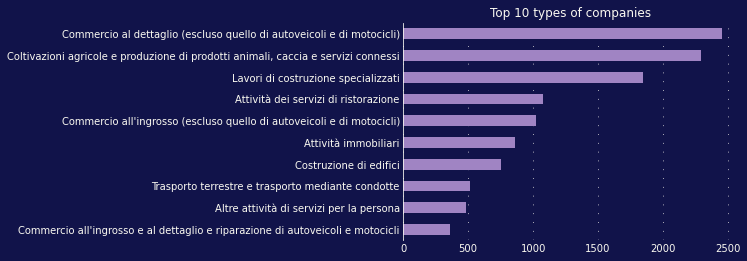

In [15]:
variety_tot['tot'] = variety_tot['tot'].nlargest( n = 10 ) # mask top 10
variety_tot = variety_tot.dropna( subset = ['tot'] ) # keep top 10
variety_tot = variety_tot.sort_values( by = ['tot'] )
fig, ax = plt.subplots()
variety_tot.plot.barh( ax = ax, 
                      x = 'ateco_nome', 
                      y = 'tot', 
                      color = lilla, 
                      legend = None, 
                     )
barth_settings(ax)
fig.patch.set_facecolor(bg)
plt.title('Top 10 types of companies')

## Districts indicators

In [16]:
indicators = pd.merge( distribution, variety_data, on = 'frazione' )
indicators['industry_variety'] = indicators['companies'] / indicators['types']
# print(isinstance(indicators, gpd.GeoDataFrame))
indicators = gpd.GeoDataFrame(indicators)
# print(indicators['types'].dtype) # object
indicators['types'] = pd.to_numeric(indicators['types'])
indicators['industry_variety'] = pd.to_numeric(indicators['industry_variety'])
print(indicators.head(3))

        frazione  companies  \
0    CASTIGLIONE        978   
1  CENTRO URBANO       3885   
2        DARSENA       1654   

                                            geometry      areas  \
0  POLYGON ((286726.373 4915066.675, 286750.492 4...  80.437160   
1  POLYGON ((278046.280 4925082.213, 278051.049 4...  21.155808   
2  POLYGON ((281218.174 4926652.414, 281326.598 4...  41.587972   

   industry_density  types  industry_variety  
0             12.16     50         19.560000  
1            183.64     73         53.219178  
2             39.77     71         23.295775  


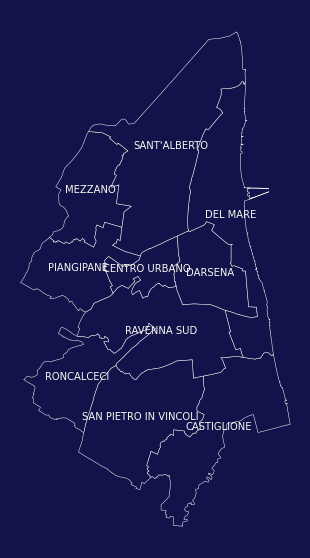

In [17]:
fig, ax = plt.subplots( figsize = (10, 10) )
indicators.plot( ax = ax, color=bg, edgecolor=txt, linewidth=.5);
plt.axis('off')
fig.patch.set_facecolor(bg)
indicators['centroid'] = indicators['geometry'].apply(lambda x: x.centroid)
for idx, row in indicators.iterrows():
    ax.annotate(text=row['frazione'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center')

Text(0.5, 1.0, 'Number of companies')

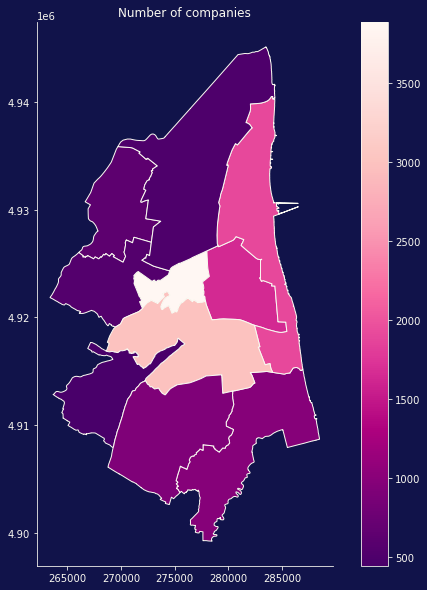

In [18]:
fig, ax = plt.subplots( figsize = (10, 10) )
indicators.plot( ax = ax,
                column = 'companies', 
                legend = True, 
                cmap = 'RdPu_r', 
                edgecolor = txt
               )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.patch.set_facecolor(bg)
plt.title('Number of companies')

Text(0.5, 1.0, 'Industry Density')

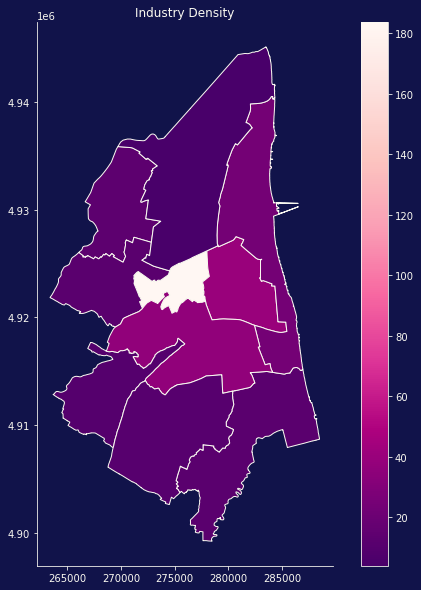

In [19]:
fig, ax = plt.subplots( figsize = (10, 10) )
indicators.plot( ax = ax, 
                column = 'industry_density', 
                legend = True, 
                cmap = 'RdPu_r', 
                edgecolor = txt
               )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.patch.set_facecolor(bg)
plt.title('Industry Density')

Text(0.5, 1.0, 'Industry Variety')

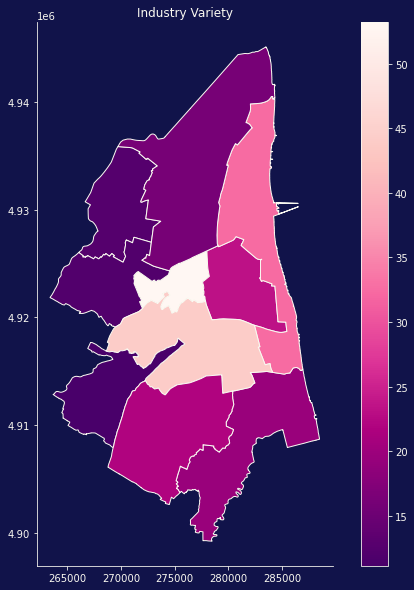

In [20]:
fig, ax = plt.subplots( figsize = (10, 10) )
indicators.plot( ax = ax, 
                column = 'industry_variety', 
                legend = True, 
                cmap = 'RdPu_r', 
                edgecolor = txt 
               )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.patch.set_facecolor(bg)
plt.title('Industry Variety')

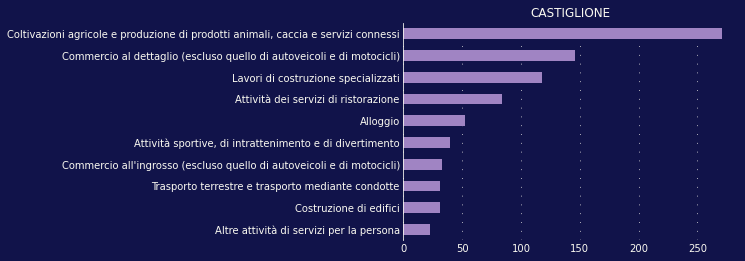

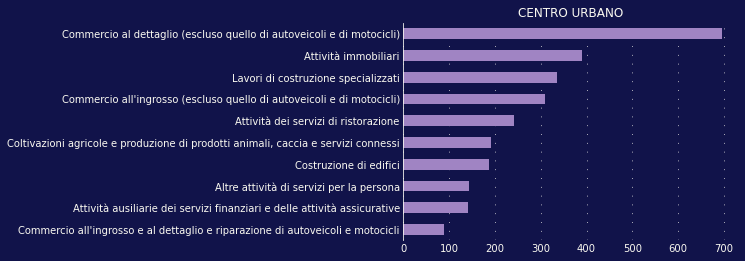

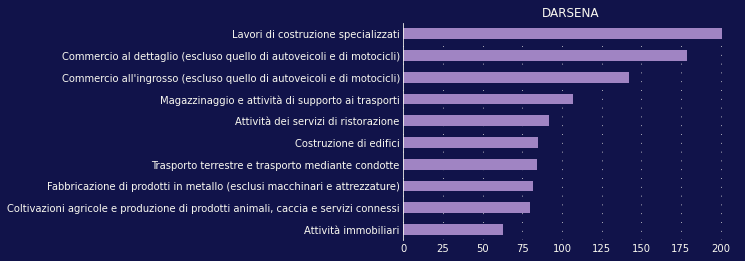

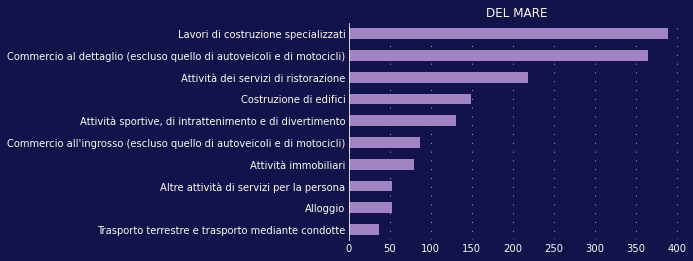

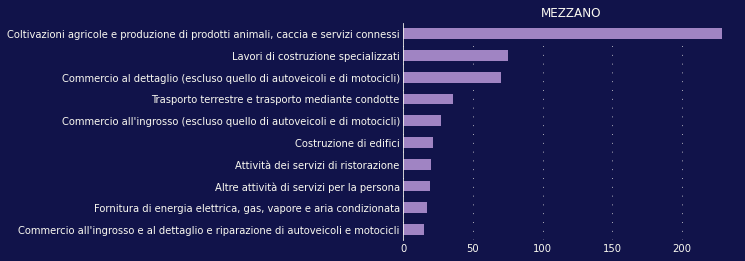

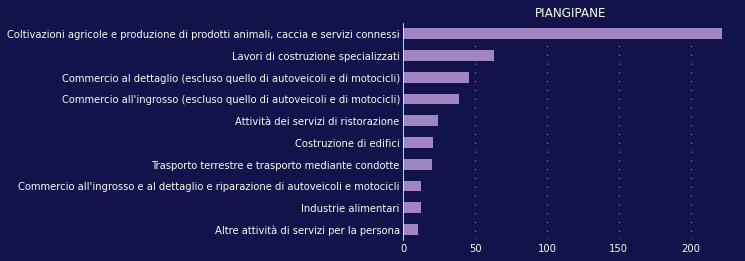

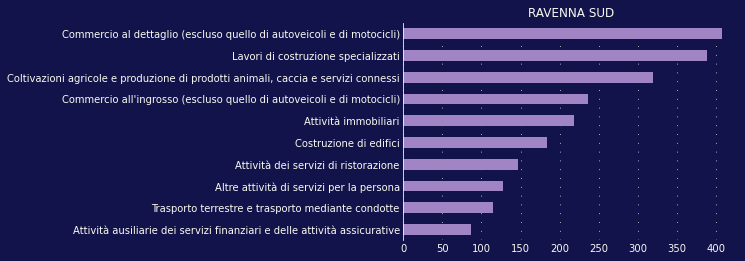

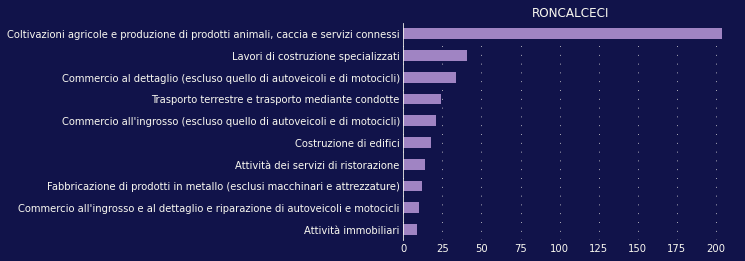

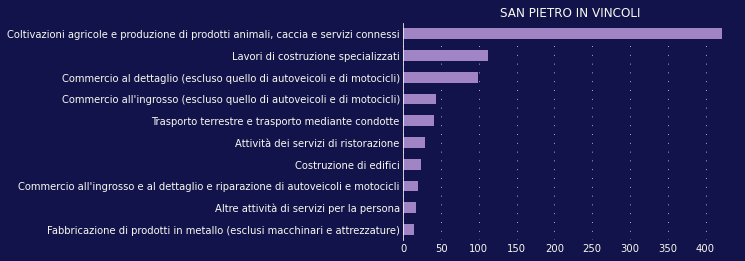

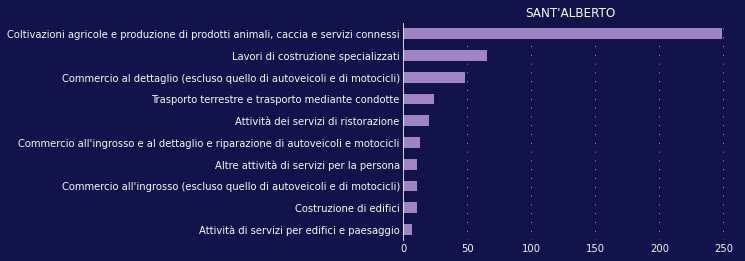

In [21]:
def distr_top(df_input, str_input):
    df = df_input[['ateco_cod', 'nome']]
    df = df.groupby('ateco_cod').count().reset_index()
    df = df.rename( columns = { 'nome' : 'tot' } )
    df = pd.merge( df, 
                  ateco, 
                  how = 'left', 
                  on = 'ateco_cod' 
                 )
    df = df[['ateco_nome', 'tot']]
    df['tot'] = df['tot'].nlargest(n = 10) # mask top 10
    df = df.dropna( subset = ['tot'] ) # keep top 10
    df = df.sort_values( by = ['tot'] )
    fig, ax = plt.subplots()
    df.plot.barh( ax = ax, 
                 x = 'ateco_nome',  
                 y = 'tot', 
                 title = str_input, 
                 color = lilla, 
                 legend = None 
                )
    barth_settings(ax)
    fig.patch.set_facecolor(bg)
    return

for name, group in variety_local:
    distr_top(group, name)